In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models.resnet import ResNet50_Weights
import lightning.pytorch as pl

from models import Model_Wrapper, Preprocess
from transforms import Luminance
from utils import View, sample_imgs

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
# configs to speed up training
torch.set_float32_matmul_precision('medium')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
PATH_TO_IMAGENET = '../../datasets/imagenet/2012/'
NUM_IMG_EVAL = 10000

In [4]:
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50 = Model_Wrapper(resnet50)
trainer = pl.Trainer(accelerator="auto", limit_test_batches=100)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
# get transforms
prep = Preprocess(PATH_TO_IMAGENET, (224, 224), shuffle=True)
preview_img_slice = slice(0, 50000, 10000)

##### Test On Orignal Dataset

In [6]:
prep.reset_trans()
imgnet_orig = prep.get_loader()
sample_orig = sample_imgs(imgnet_orig, preview_img_slice)

In [7]:
# test model on original images
result_orig = trainer.test(resnet50, imgnet_orig)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-27 14:04:56.694140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 14:04:56.980708: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-27 14:04:57.656422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jon/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-27 14:04:57.656706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.7844531536102295     │
│         test_acc5         │     0.942187488079071     │
│         test_loss         │    1.4958420991897583     │
└───────────────────────────┴───────────────────────────┘

##### Test Histogram Eq on Dark Images

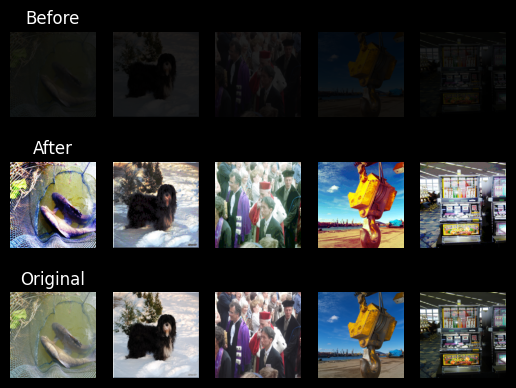

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.6802343726158142     │
│         test_acc5         │    0.8803906440734863     │
│         test_loss         │    1.9677482843399048     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.7359374761581421     │
│         test_acc5         │    0.9184374809265137     │
│         test_loss         │    1.6747255325317383     │
└───────────────────────────┴───────────────────────────┘

In [8]:
prep.reset_trans()
imgnet_dark = prep.luminance(1/8).get_loader()
imgnet_dark_histeq = prep.hist_eq().get_loader()

sample_dark = sample_imgs(imgnet_dark, preview_img_slice)
sample_dark_histeq = sample_imgs(imgnet_dark_histeq, preview_img_slice)
View.compare3_color(sample_dark, sample_dark_histeq, sample_orig)

# test model on dark images and histeq
result_dark = trainer.test(resnet50, imgnet_dark)
result_dark_histeq = trainer.test(resnet50, imgnet_dark_histeq)

##### Test Retinex on Dark Images

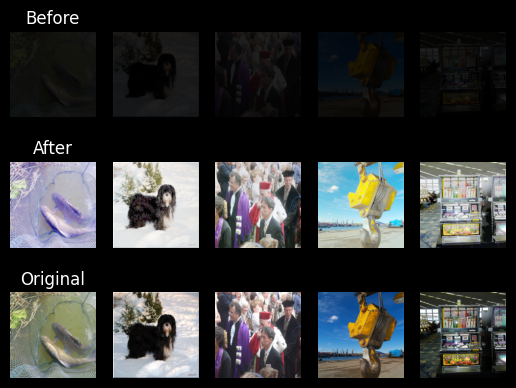

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.7295312285423279     │
│         test_acc5         │    0.9138281345367432     │
│         test_loss         │    1.7112677097320557     │
└───────────────────────────┴───────────────────────────┘

In [9]:
prep.reset_trans()
imgnet_dark = prep.luminance(1/8).get_loader()
imgnet_dark_retinex = prep.retinex('SSR', 100).get_loader()

sample_dark = sample_imgs(imgnet_dark, preview_img_slice)
sample_dark_retinex = sample_imgs(imgnet_dark_retinex, preview_img_slice)
View.compare3_color(sample_dark, sample_dark_retinex, sample_orig)

# test model on dark images and retinex
# result_dark = trainer.test(resnet50, imgnet_dark)
result_dark_retinex = trainer.test(resnet50, imgnet_dark_retinex)

##### Test Histogram Eq on Bright Images

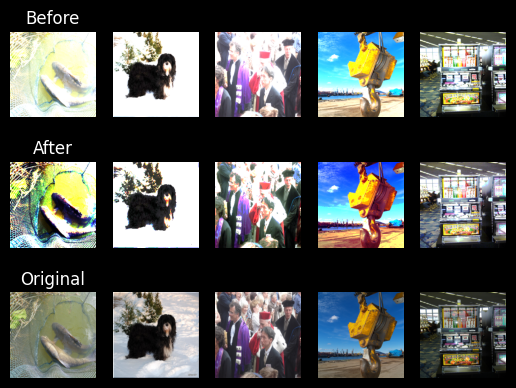

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.7198437452316284     │
│         test_acc5         │    0.9034374952316284     │
│         test_loss         │    1.7537230253219604     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.6764843463897705     │
│         test_acc5         │    0.8759375214576721     │
│         test_loss         │    1.9265844821929932     │
└───────────────────────────┴───────────────────────────┘

In [10]:
prep.reset_trans()
imgnet_bright = prep.luminance(2).get_loader()
imgnet_bright_histeq = prep.hist_eq().get_loader()

sample_bright = sample_imgs(imgnet_bright, preview_img_slice)
sample_bright_histeq = sample_imgs(imgnet_bright_histeq, preview_img_slice)

View.compare3_color(sample_bright, sample_bright_histeq, sample_orig)

# test model on bright images and histeq
result_bright = trainer.test(resnet50, imgnet_bright)
result_bright_histeq = trainer.test(resnet50, imgnet_bright_histeq)

##### Test Retinex on Bright Images

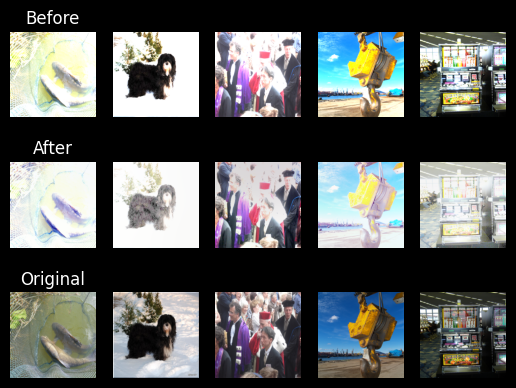

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.6268749833106995     │
│         test_acc5         │    0.8391406536102295     │
│         test_loss         │    2.1504979133605957     │
└───────────────────────────┴───────────────────────────┘

In [11]:
prep.reset_trans()
imgnet_bright = prep.luminance(2).get_loader()
imgnet_bright_retinex = prep.retinex('SSR', 100).get_loader()

sample_bright = sample_imgs(imgnet_bright, preview_img_slice)
sample_bright_retinex = sample_imgs(imgnet_bright_retinex, preview_img_slice)
View.compare3_color(sample_bright, sample_bright_retinex, sample_orig)

# test model on bright images and retinex
# result_bright = trainer.test(resnet50, imgnet_bright)
result_bright_retinex = trainer.test(resnet50, imgnet_bright_retinex)

##### Test Histogram Eq on Low Contrast Images

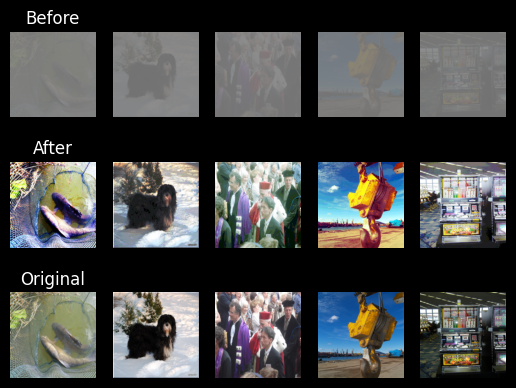

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.6508593559265137     │
│         test_acc5         │    0.8564062714576721     │
│         test_loss         │     2.08892560005188      │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.7341406345367432     │
│         test_acc5         │    0.9139843583106995     │
│         test_loss         │    1.6950500011444092     │
└───────────────────────────┴───────────────────────────┘

In [12]:
prep.reset_trans()
imgnet_low_contrast = prep.brightness_contrast(0, 0.1).get_loader()
imgnet_low_contrast_histeq = prep.hist_eq().get_loader()

sample_low_contrast = sample_imgs(imgnet_low_contrast, preview_img_slice)
sample_low_contrast_histeq = sample_imgs(imgnet_low_contrast_histeq, preview_img_slice)

View.compare3_color(sample_low_contrast, sample_low_contrast_histeq, sample_orig)

result_low_contrast = trainer.test(resnet50, imgnet_low_contrast)
result_low_contrast_histeq = trainer.test(resnet50, imgnet_low_contrast_histeq)

##### Test Retinex on low contrast images

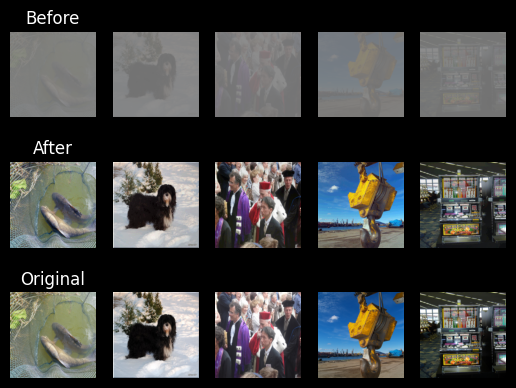

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.7755468487739563     │
│         test_acc5         │    0.9393749833106995     │
│         test_loss         │     1.512585163116455     │
└───────────────────────────┴───────────────────────────┘

In [13]:
prep.reset_trans()
imgnet_low_contrast = prep.brightness_contrast(0, 0.1).get_loader()
imgnet_low_contrast_retinex = prep.retinex('SSR', 100).get_loader()

sample_low_contrast = sample_imgs(imgnet_low_contrast, preview_img_slice)
sample_low_contrast_retinex = sample_imgs(imgnet_low_contrast_retinex, preview_img_slice)

View.compare3_color(sample_low_contrast, sample_low_contrast_retinex, sample_orig)

# result_low_contrast = trainer.test(resnet50, imgnet_low_contrast)
result_low_contrast_retinex = trainer.test(resnet50, imgnet_low_contrast_retinex)

##### Test sharpening on blurry images

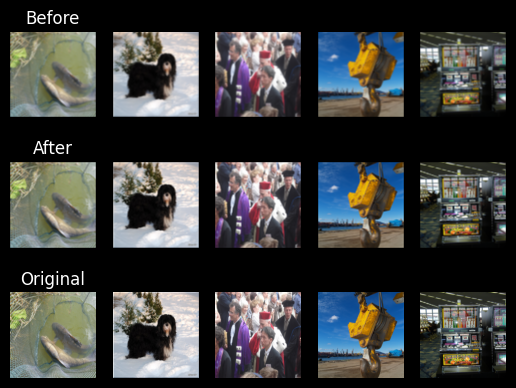

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.6102343797683716     │
│         test_acc5         │    0.8277343511581421     │
│         test_loss         │     2.283360481262207     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │     0.649218738079071     │
│         test_acc5         │    0.8597656488418579     │
│         test_loss         │     2.091397523880005     │
└───────────────────────────┴───────────────────────────┘

In [14]:
prep.reset_trans()
imgnet_mod = prep.blur(5).get_loader()
imgnet_mod_filt = prep.sharpen(5).get_loader()

sample_mod = sample_imgs(imgnet_mod, preview_img_slice)
sample_mod_filter = sample_imgs(imgnet_mod_filt, preview_img_slice)

View.compare3_color(sample_mod, sample_mod_filter, sample_orig)

result_mod = trainer.test(resnet50, imgnet_mod)
result_mod_filt = trainer.test(resnet50, imgnet_mod_filt)